CS 417/517: Introduction to Human Computer Interaction -
Project 1 ( Fall 2024 )

TASK 1 :

Build your customized Convolution Neural Network (CNN)

• Define the architecture of a Convolution Neural Network (CNN) with more than 3 layers, that takes these images as input and gives as output what the handwritten digits represent for this image.

• Test your machine learning model on the testing set: After finishing the architecture of CNN models, fix your hyper-parameters(learning rate, lambda for penalty, number of layers, and number of neurons per layer), and test your model’s performance on the testing set.

• Implement different optimizer (i.e., at least two). Compare the results in report and analyze the potential reasons.

• Implement different regularization methods for the Neural Networks, such as Dropout, l1 or l2.

Compare the results in report and analyze the potential reasons.

In [2]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from google.colab import files
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
import torch.nn.functional as F
import imutils
from imutils import contours


# mount google drive to access video and save results
drive.mount('/content/drive')

# check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# step 1: download and prepare the dataset
# initial transform to convert images to tensors
initial_transform = transforms.Compose([
    transforms.ToTensor()
])

# download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=initial_transform, download=True)

# calculate the mean and standard deviation of the training data
train_data = train_dataset.data.float() / 255  # scale data to [0,1]
mean = train_data.mean().item()
std = train_data.std().item()
print(f'Calculated mean of scaled pixel values (train data): {mean}')
print(f'Calculated std of scaled pixel values (train data): {std}')

# define the transform with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# apply the normalization transform to both the training and test datasets
train_dataset.transform = transform
test_dataset.transform = transform

# step 2: create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Calculated mean of scaled pixel values (train data): 0.13066047430038452
Calculated std of scaled pixel values (train data): 0.30810782313346863


In [3]:
# step 3: define the custom convolutional neural network
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.model = nn.Sequential(
            # first convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # first max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # second max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # flatten layer
            nn.Flatten(start_dim=1, end_dim=-1),
            # first fully connected layer
            nn.Linear(in_features=3136, out_features=1024, bias=True),
            nn.ReLU(),
            # dropout layer for regularization
            nn.Dropout(p=0.2, inplace=False),
            # output layer
            nn.Linear(in_features=1024, out_features=10, bias=True)
        ).to(device)

    def forward(self, x):
        return self.model(x)

print(f"Number of parameters in the model: {sum(p.numel() for p in ConvNeuralNet().parameters() if p.requires_grad)}")

print(ConvNeuralNet())

Number of parameters in the model: 3241354
ConvNeuralNet(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [4]:
# step 4: define training and testing functions
def train(model, device, train_loader, optimizer, epoch, l1_lambda=0):
    model.train()
    total_correct = 0
    total_loss = 0
    print(f'Epoch ({epoch})')
    print('————————')

    # loop through each batch in the training data loader
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)    # move data to device
        optimizer.zero_grad()
        output = model(data)           # model output for the current batch
        loss = loss_fn(output, target)      # loss calculation

        # l1 regularization
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

        loss.backward()           # backpropagation
        optimizer.step()          # updating the model weights

        total_loss += loss.item()         # add the current loss to the total loss
        pred = output.argmax(dim=1, keepdim=True)
        total_correct += pred.eq(target.view_as(pred)).sum().item()     # total number of correct predictions

        # print the loss every fifth of the dataset
        if batch_idx % (len(train_loader) // 5) == 0:
            print(f'loss: {loss.item():.4f} [{batch_idx * len(data)}/{len(train_loader.dataset)}]')

    # calculate the average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * total_correct / len(train_loader.dataset)
    print(f'\nTrain Accuracy: {accuracy:.2f}%')
    print('————————————————')
    return avg_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    print('————————')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            if batch_idx % (len(test_loader) // 5) == 0:
                print(f'loss: {test_loss:.4f} [{batch_idx * len(data)}/{len(test_loader.dataset)}]')

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest Accuracy: {accuracy:.2f}%\t Avg Loss: {test_loss:.4f}')
    print('————————————————')
    return test_loss, accuracy

In [5]:
# step 5: define different optimizers and regularization methods to compare
optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}

regularizations = {
    'None': {'weight_decay': 0, 'l1_lambda': 0},
    'L2': {'weight_decay': 1e-5, 'l1_lambda': 0},
    'L1': {'weight_decay': 0, 'l1_lambda': 1e-5}
}

In [6]:
# step 6: run training and testing for each combination of optimizer and regularization
results = {}
best_accuracy = 0.0  # to store the highest accuracy
best_model_state = None  # to store the state dict of the best model
model_save_path = '/content/drive/MyDrive/best_model.pth'  # path to save the best model

for reg_name, reg_params in regularizations.items():
    for opt_name, opt_class in optimizers.items():
        print(f'\nTraining with optimizer: {opt_name} and regularization: {reg_name}\n')
        model = ConvNeuralNet().to(device)
        # define loss function
        loss_fn = nn.CrossEntropyLoss()
        # define optimizer with appropriate regularization parameters
        optimizer = opt_class(model.parameters(), lr=0.001, weight_decay=reg_params['weight_decay'])
        # lists to store loss and accuracy values
        train_losses, train_accuracies = [], []
        test_losses, test_accuracies = [], []
        # training loop
        for epoch in range(1, 6):
            train_loss, train_acc = train(model, device, train_loader, optimizer, epoch, l1_lambda=reg_params['l1_lambda'])
            test_loss, test_acc = test(model, device, test_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)

            # Save the model if it has the best accuracy so far
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_model_state = model.state_dict()  # store the best model's parameters

        # store the results
        key = f'{opt_name}_{reg_name}'
        results[key] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies
        }

# Save the best model to disk
if best_model_state:
    torch.save(best_model_state, model_save_path)
    print(f"Best model saved with test accuracy: {best_accuracy:.2f}% at {model_save_path}")


Training with optimizer: Adam and regularization: None

Epoch (1)
————————
loss: 2.3011 [0/60000]
loss: 0.0432 [11968/60000]
loss: 0.4769 [23936/60000]
loss: 0.0465 [35904/60000]
loss: 0.0012 [47872/60000]
loss: 0.1061 [59840/60000]

Train Accuracy: 96.45%
————————————————
————————
loss: 0.0404 [0/10000]
loss: 0.1913 [2000/10000]
loss: 0.3012 [4000/10000]
loss: 0.3644 [6000/10000]
loss: 0.4004 [8000/10000]

Test Accuracy: 98.45%	 Avg Loss: 0.0447
————————————————
Epoch (2)
————————
loss: 0.0198 [0/60000]
loss: 0.0058 [11968/60000]
loss: 0.0291 [23936/60000]
loss: 0.0086 [35904/60000]
loss: 0.0182 [47872/60000]
loss: 0.0305 [59840/60000]

Train Accuracy: 98.78%
————————————————
————————
loss: 0.0405 [0/10000]
loss: 0.1431 [2000/10000]
loss: 0.2190 [4000/10000]
loss: 0.2626 [6000/10000]
loss: 0.2762 [8000/10000]

Test Accuracy: 99.02%	 Avg Loss: 0.0303
————————————————
Epoch (3)
————————
loss: 0.0284 [0/60000]
loss: 0.0812 [11968/60000]
loss: 0.0020 [23936/60000]
loss: 0.0455 [35904/600

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

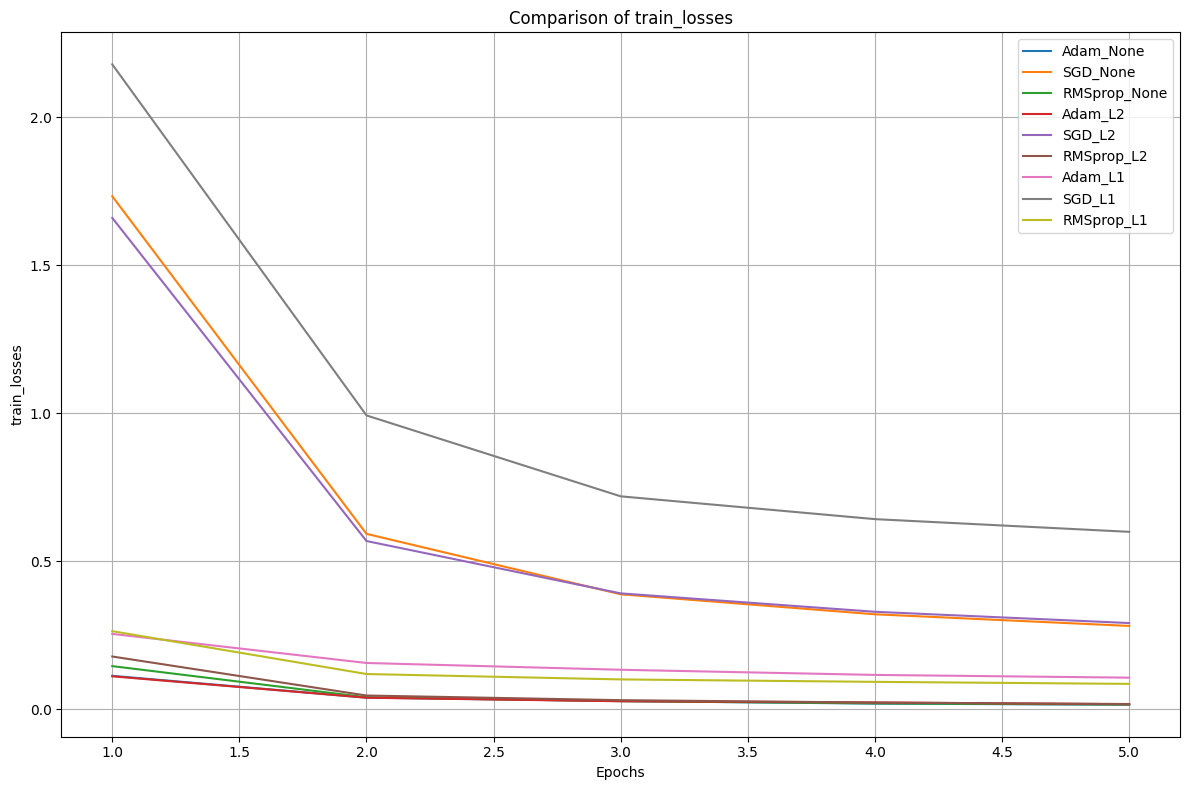

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

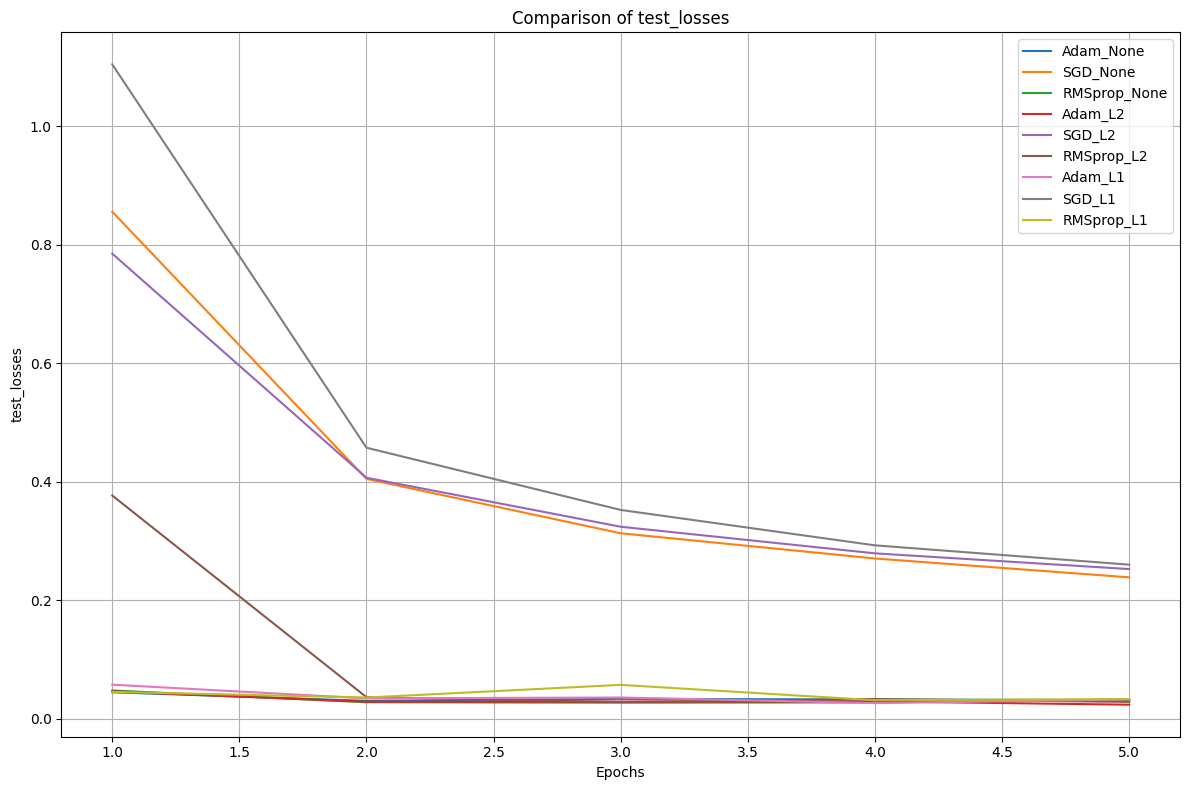

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

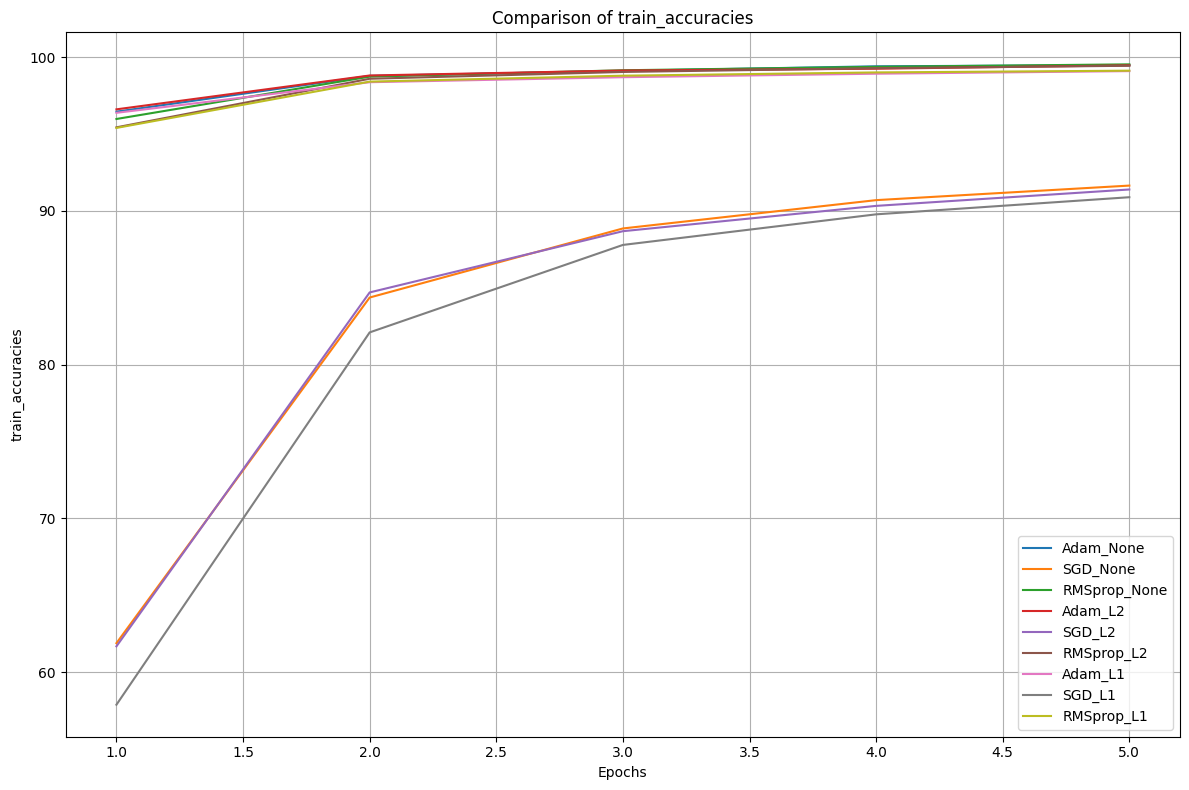

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

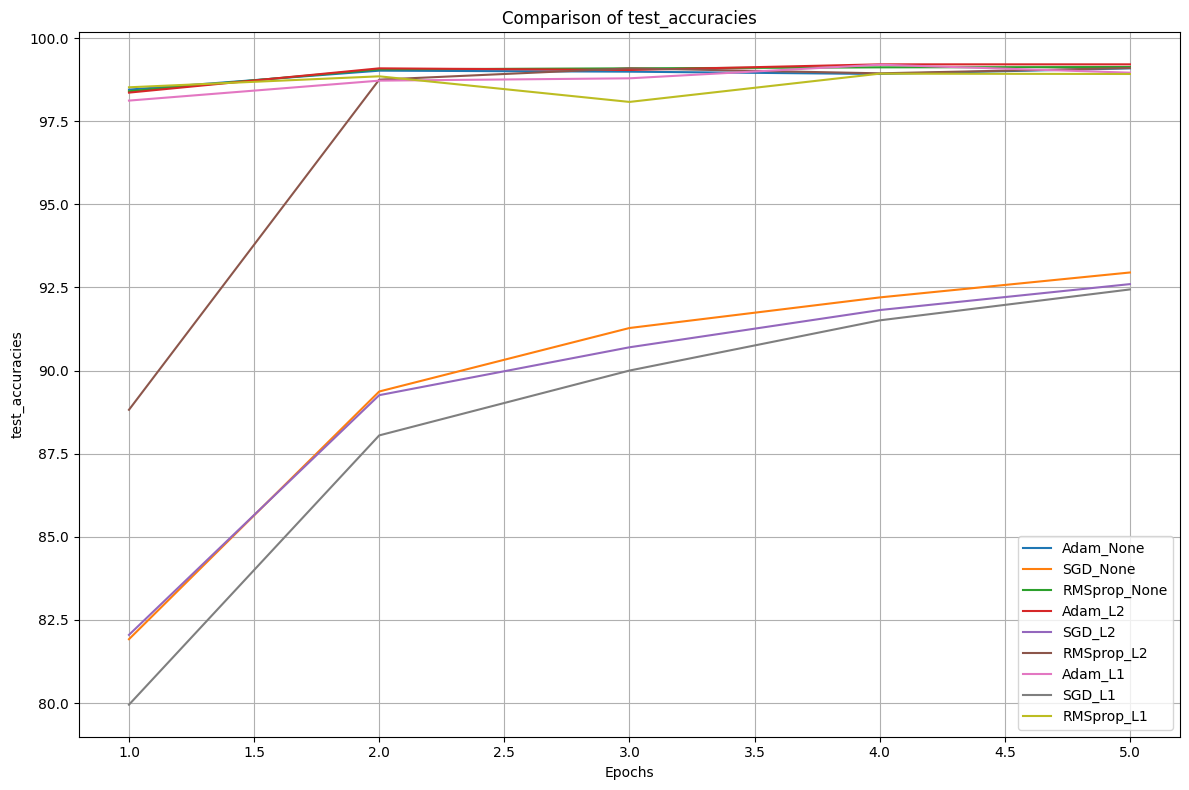

In [7]:
# step 7: plot and compare the results
# function to plot the results
def plot_results(results, metric):
    plt.figure(figsize=(12, 8))
    for key in results:
        epochs = range(1, len(results[key][metric]) + 1)
        plt.plot(epochs, results[key][metric], label=key)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.pdf')
    files.download(f'{metric}_comparison.pdf')
    plt.show()

# plot training losses
plot_results({k: v for k, v in results.items()}, 'train_losses')
# plot test losses
plot_results({k: v for k, v in results.items()}, 'test_losses')
# plot training accuracies
plot_results({k: v for k, v in results.items()}, 'train_accuracies')
# plot test accuracies
plot_results({k: v for k, v in results.items()}, 'test_accuracies')


In [8]:
# step 8: print out the final accuracies for comparison
print('\nFinal Test Accuracies:')
for key in results:
    print(f'{key}: {results[key]["test_accuracies"][-1]:.2f}%')


Final Test Accuracies:
Adam_None: 99.09%
SGD_None: 92.95%
RMSprop_None: 99.13%
Adam_L2: 99.21%
SGD_L2: 92.60%
RMSprop_L2: 99.10%
Adam_L1: 98.96%
SGD_L1: 92.44%
RMSprop_L1: 98.92%


Code Task (2) Fine-tune at least three different well-pretrained models (e.g., MobileNetV3, Resnet50 ) to get a good performance.

In [9]:
# MNIST-specific mean and std as calculated in task 1
mnist_mean = [0.13066047430038452] * 3  # Replicate across 3 channels
mnist_std = [0.30810782313346863] * 3  # Replicate across 3 channels

# define the transform for pre-trained models
pretrained_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),  # convert 1-channel grayscale to 3-channel images
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

# update the datasets with the new transform
train_dataset_pretrained = datasets.MNIST(root='./data', train=True, transform=pretrained_transform, download=True)
test_dataset_pretrained = datasets.MNIST(root='./data', train=False, transform=pretrained_transform, download=True)

# used a smaller batch size to reduce memory usage
pretrained_batch_size = 16

train_loader_pretrained = torch.utils.data.DataLoader(
    dataset=train_dataset_pretrained,
    batch_size=pretrained_batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True  # improves transfer speed to GPU
)
test_loader_pretrained = torch.utils.data.DataLoader(
    dataset=test_dataset_pretrained,
    batch_size=pretrained_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# function to fine-tune a pre-trained model
def fine_tune_model(model_name):
    if model_name == 'ResNet50':
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        # replace the final fully connected layer
        model.fc = nn.Linear(num_features, 10)
        # freeze all layers except the last layer
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    elif model_name == 'MobileNetV2':
        model = models.mobilenet_v2(pretrained=True)
        num_features = model.classifier[1].in_features
        # replace the classifier
        model.classifier[1] = nn.Linear(num_features, 10)
        # freeze all layers except the classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif model_name == 'VGG16':
        model = models.vgg16(pretrained=True)
        num_features = model.classifier[6].in_features
        # replace the classifier
        model.classifier[6] = nn.Linear(num_features, 10)
        # freeze all layers except the classifier
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    else:
        print('model not supported.')
        return None
    return model.to(device)

In [10]:
# fine-tune and evaluate pre-trained models
pretrained_models = ['ResNet50', 'MobileNetV2', 'VGG16']
pretrained_results = {}

# clear GPU memory before starting
torch.cuda.empty_cache()

for model_name in pretrained_models:
    print(f'\nfine-tuning {model_name}\n')
    model = fine_tune_model(model_name)
    # define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    # lists to store loss and accuracy values
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    # training loop
    for epoch in range(1, 6):
        train_loss, train_acc = train(model, device, train_loader_pretrained, optimizer, epoch)
        test_loss, test_acc = test(model, device, test_loader_pretrained)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    # store the results
    pretrained_results[model_name] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }
    # clear GPU memory after each model
    del model
    torch.cuda.empty_cache()



fine-tuning ResNet50



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


Epoch (1)
————————
loss: 2.4205 [0/60000]
loss: 0.2533 [12000/60000]
loss: 0.2367 [24000/60000]
loss: 0.5013 [36000/60000]
loss: 0.0950 [48000/60000]

Train Accuracy: 86.97%
————————————————
————————
loss: 0.1090 [0/10000]
loss: 32.7883 [2000/10000]
loss: 66.7188 [4000/10000]
loss: 94.4277 [6000/10000]
loss: 117.1357 [8000/10000]

Test Accuracy: 93.04%	 Avg Loss: 0.2212
————————————————
Epoch (2)
————————
loss: 0.1924 [0/60000]
loss: 0.2920 [12000/60000]
loss: 0.1710 [24000/60000]
loss: 0.2161 [36000/60000]
loss: 0.3430 [48000/60000]

Train Accuracy: 90.96%
————————————————
————————
loss: 0.1654 [0/10000]
loss: 26.8541 [2000/10000]
loss: 54.9128 [4000/10000]
loss: 76.3869 [6000/10000]
loss: 93.8669 [8000/10000]

Test Accuracy: 94.54%	 Avg Loss: 0.1736
————————————————
Epoch (3)
————————
loss: 0.1290 [0/60000]
loss: 0.1480 [12000/60000]
loss: 0.1531 [24000/60000]
loss: 0.1415 [36000/60000]
loss: 0.1435 [48000/60000]

Train Accuracy: 92.17%
————————————————
————————
loss: 0.1275 [0/10000

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Test Accuracy: 94.96%	 Avg Loss: 0.1589
————————————————

fine-tuning MobileNetV2



100%|██████████| 13.6M/13.6M [00:00<00:00, 140MB/s]

Epoch (1)
————————


loss: 2.4866 [0/60000]
loss: 0.2329 [12000/60000]
loss: 1.2782 [24000/60000]
loss: 0.5133 [36000/60000]
loss: 0.3886 [48000/60000]

Train Accuracy: 88.62%
————————————————
————————
loss: 0.0222 [0/10000]
loss: 27.0509 [2000/10000]
loss: 54.9311 [4000/10000]
loss: 80.0962 [6000/10000]
loss: 98.6097 [8000/10000]

Test Accuracy: 93.89%	 Avg Loss: 0.1886
————————————————
Epoch (2)
————————
loss: 0.2323 [0/60000]
loss: 0.1801 [12000/60000]
loss: 0.1731 [24000/60000]
loss: 0.3908 [36000/60000]
loss: 0.2477 [48000/60000]

Train Accuracy: 91.58%
————————————————
————————
loss: 0.0075 [0/10000]
loss: 18.4267 [2000/10000]
loss: 40.4566 [4000/10000]
loss: 58.1797 [6000/10000]
loss: 71.2632 [8000/10000]

Test Accuracy: 95.69%	 Avg Loss: 0.1366
————————————————
Epoch (3)
————————
loss: 0.2416 [0/60000]
loss: 0.2365 [12000/60000]
loss: 0.1790 [24000/60000]
loss: 0.0767 [36000/60000]
loss: 0.3094 [48000/60000]

Train Accuracy: 91.90%
————————————————
————————
loss: 0.0090 [0/10000]
loss: 17.2872 [200

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.4MB/s]


Epoch (1)
————————
loss: 2.5240 [0/60000]
loss: 0.2094 [12000/60000]
loss: 1.2528 [24000/60000]
loss: 0.0000 [36000/60000]
loss: 0.0000 [48000/60000]

Train Accuracy: 94.02%
————————————————
————————
loss: 0.0000 [0/10000]
loss: 42.3836 [2000/10000]
loss: 73.1513 [4000/10000]
loss: 91.9901 [6000/10000]
loss: 105.2593 [8000/10000]

Test Accuracy: 98.22%	 Avg Loss: 0.2029
————————————————
Epoch (2)
————————
loss: 0.0000 [0/60000]
loss: 0.0002 [12000/60000]
loss: 0.3000 [24000/60000]
loss: 0.5346 [36000/60000]
loss: 0.6855 [48000/60000]

Train Accuracy: 96.61%
————————————————
————————
loss: 0.0000 [0/10000]
loss: 23.7803 [2000/10000]
loss: 54.2990 [4000/10000]
loss: 74.7194 [6000/10000]
loss: 78.9497 [8000/10000]

Test Accuracy: 98.26%	 Avg Loss: 0.1489
————————————————
Epoch (3)
————————
loss: 0.0130 [0/60000]
loss: 0.0000 [12000/60000]
loss: 0.0565 [24000/60000]
loss: 2.5377 [36000/60000]
loss: 0.0000 [48000/60000]

Train Accuracy: 97.07%
————————————————
————————
loss: 0.0000 [0/10000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

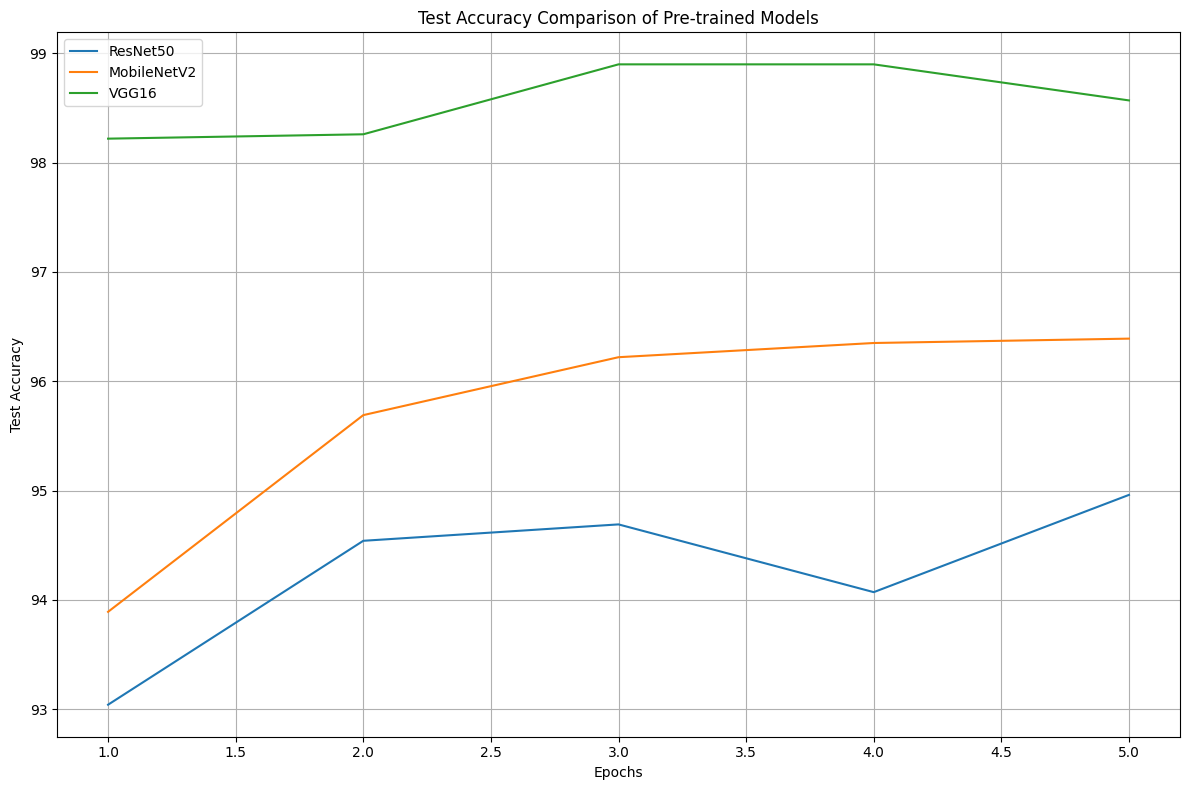


Final Test Accuracies of Pre-trained Models:
ResNet50: 94.96%
MobileNetV2: 96.39%
VGG16: 98.57%


In [11]:
# plot and compare pre-trained models' performance
plt.figure(figsize=(12, 8))
for model_name in pretrained_results:
    epochs = range(1, len(pretrained_results[model_name]['test_accuracies']) + 1)
    plt.plot(epochs, pretrained_results[model_name]['test_accuracies'], label=model_name)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison of Pre-trained Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Pretrained_Test_Accuracy_Comparison.pdf')
files.download('Pretrained_Test_Accuracy_Comparison.pdf')
plt.show()

print('\nFinal Test Accuracies of Pre-trained Models:')
for model_name in pretrained_results:
    print(f'{model_name}: {pretrained_results[model_name]["test_accuracies"][-1]:.2f}%')

Code Task (3): This code task is only for CS517. Recognize handwritten digits from a recorded video using the pre-trained model and OpenCV libraries.

In [12]:
# loading the pretrained model
inference_model = ConvNeuralNet().to(device)
inference_model.load_state_dict(torch.load(model_save_path, map_location=device))
inference_model.eval()
print('Best model loaded and set to evaluation mode for inference')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Best model loaded and set to evaluation mode for inference


<ipython-input-12-025f90f1aff2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_model.load_state_dict(torch.load(model_save_path, map_location=device))


In [17]:
# function to display images
def display_images(frames, cols=2, figsize=(15, 15)):
    if not frames:
        print("No frames to display.")
        return

    rows = len(frames) // cols + int(len(frames) % cols != 0)
    plt.figure(figsize=figsize)

    for i, frame in enumerate(frames):
        plt.subplot(rows, cols, i + 1)
        # Convert BGR (OpenCV format) to RGB for correct color display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# function to select frames
def select_frame_indices(total_frames, num_frames, min_gap, max_gap, method='deterministic'):
    selected_indices = []
    if method == 'deterministic':
        # Evenly spaced selection
        if num_frames * min_gap > total_frames:
            print("Warning: Not enough frames to maintain the minimum gap. Adjusting the number of frames to select.")
            num_frames = max(total_frames // min_gap, 1)

        step = total_frames // (num_frames + 1)
        selected_indices = [i * step for i in range(1, num_frames + 1)]

    elif method == 'random':
        # Randomly select frames with gaps
        current_index = 0
        while len(selected_indices) < num_frames and current_index < total_frames:
            selected_indices.append(current_index)
            gap = random.randint(min_gap, max_gap)
            current_index += gap

        # Ensure indices do not exceed total_frames
        selected_indices = [min(idx, total_frames - 1) for idx in selected_indices]

    else:
        raise ValueError("Invalid selection method. Choose 'deterministic' or 'random'.")

    return selected_indices

# function to skew of digit images to align
def deskew(image, SZ=28):
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        # No deskewing needed
        return image.copy()

    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SZ * skew], [0, 1, 0]])
    img = cv2.warpAffine(
        image,
        M,
        (SZ, SZ),
        flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR
    )
    return img

# function to normalize the region of interest (ROI) containing a digit
def normalize_roi(bin_roi, SZ=28):
    # Calculate scaling factor
    s = 1.5 * float(bin_roi.shape[0]) / SZ

    # Calculate moments to find the center of mass
    m = cv2.moments(bin_roi)
    if m['m00'] == 0:
        # Avoid division by zero; return resized image
        return cv2.resize(bin_roi, (SZ, SZ))

    c1 = np.float32([m['m10'], m['m01']]) / m['m00']
    c0 = np.float32([SZ / 2, SZ / 2])
    t = c1 - s * c0

    # Construct affine transformation matrix
    A = np.zeros((2, 3), np.float32)
    A[:, :2] = np.eye(2) * s
    A[:, 2] = t

    # Apply affine transformation to scale and translate the image
    bin_norm = cv2.warpAffine(
        bin_roi,
        A,
        (SZ, SZ),
        flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR
    )

    # Deskew the normalized image
    bin_norm = deskew(bin_norm, SZ)

    return bin_norm

In [20]:
# load video
video_path = '/content/drive/MyDrive/IMG_6419.mov'
cap = cv2.VideoCapture(video_path)

# total no. of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total no. of frames in the video: {total_frames}")

# selection parameters
num_selected_frames = 6
min_gap = 5
max_gap = 40
selection_method = 'deterministic'

selected_indices = select_frame_indices(total_frames, num_selected_frames, min_gap, max_gap, method=selection_method)
print(f"Selected frame indices: {selected_indices}")

# initialize a list to store marked frames
marked_frames = []

current_frame = 0
selected_set = set(selected_indices)

while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    if current_frame in selected_set:
        print(f"Processing frame {current_frame}")
        # Resize the frame for consistent processing
        frame_resized = cv2.resize(frame, (640, 480))

        # Convert to grayscale
        gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding
        bin_img = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY_INV,
            31, 10
        )

        # Apply median blur to reduce noise
        bin_img = cv2.medianBlur(bin_img, 3)

        # Find contours
        contours, hierarchy = cv2.findContours(bin_img.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        if hierarchy is not None:
            hierarchy = hierarchy[0]
        else:
            hierarchy = []

        # Initialize digit contours list
        digit_contours = []
        for idx, cnt in enumerate(contours):
            # Skip if it's a child contour
            if hierarchy[idx][3] != -1:
                continue

            x, y, w, h = cv2.boundingRect(cnt)
            if 16 <= h <= 64 and w <= 1.2 * h:
                digit_contours.append((x, y, w, h))

        # Sort contours from left to right
        digit_contours = sorted(digit_contours, key=lambda b: b[0])

        # Loop over digit regions
        for (x, y, w, h) in digit_contours:
            roi = bin_img[y:y + h, x:x + w]

            # Normalize ROI
            bin_norm = normalize_roi(roi, SZ=28)

            # Ensure bin_norm is binary
            _, bin_norm = cv2.threshold(bin_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Convert to tensor and normalize
            roi_tensor = transform(bin_norm).unsqueeze(0).to(device)

            # Prediction
            with torch.no_grad():
                output = inference_model(roi_tensor)
                probs = F.softmax(output, dim=1)
                confidence, pred = torch.max(probs, 1)
                digit = pred.item()
                confidence_score = confidence.item()

            # Annotation
            label = f"{digit} ({confidence_score * 100:.1f}%)"
            cv2.rectangle(frame_resized, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(
                frame_resized, label, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2
            )

        # Append marked frame
        marked_frames.append(frame_resized)

    current_frame += 1

cap.release()

print(f"Total marked frames selected: {len(marked_frames)}")


Total no. of frames in the video: 96
Selected frame indices: [13, 26, 39, 52, 65, 78]
Processing frame 13
Processing frame 26
Processing frame 39
Processing frame 52
Processing frame 65
Processing frame 78
Total marked frames selected: 6


Displaying annotated frames...


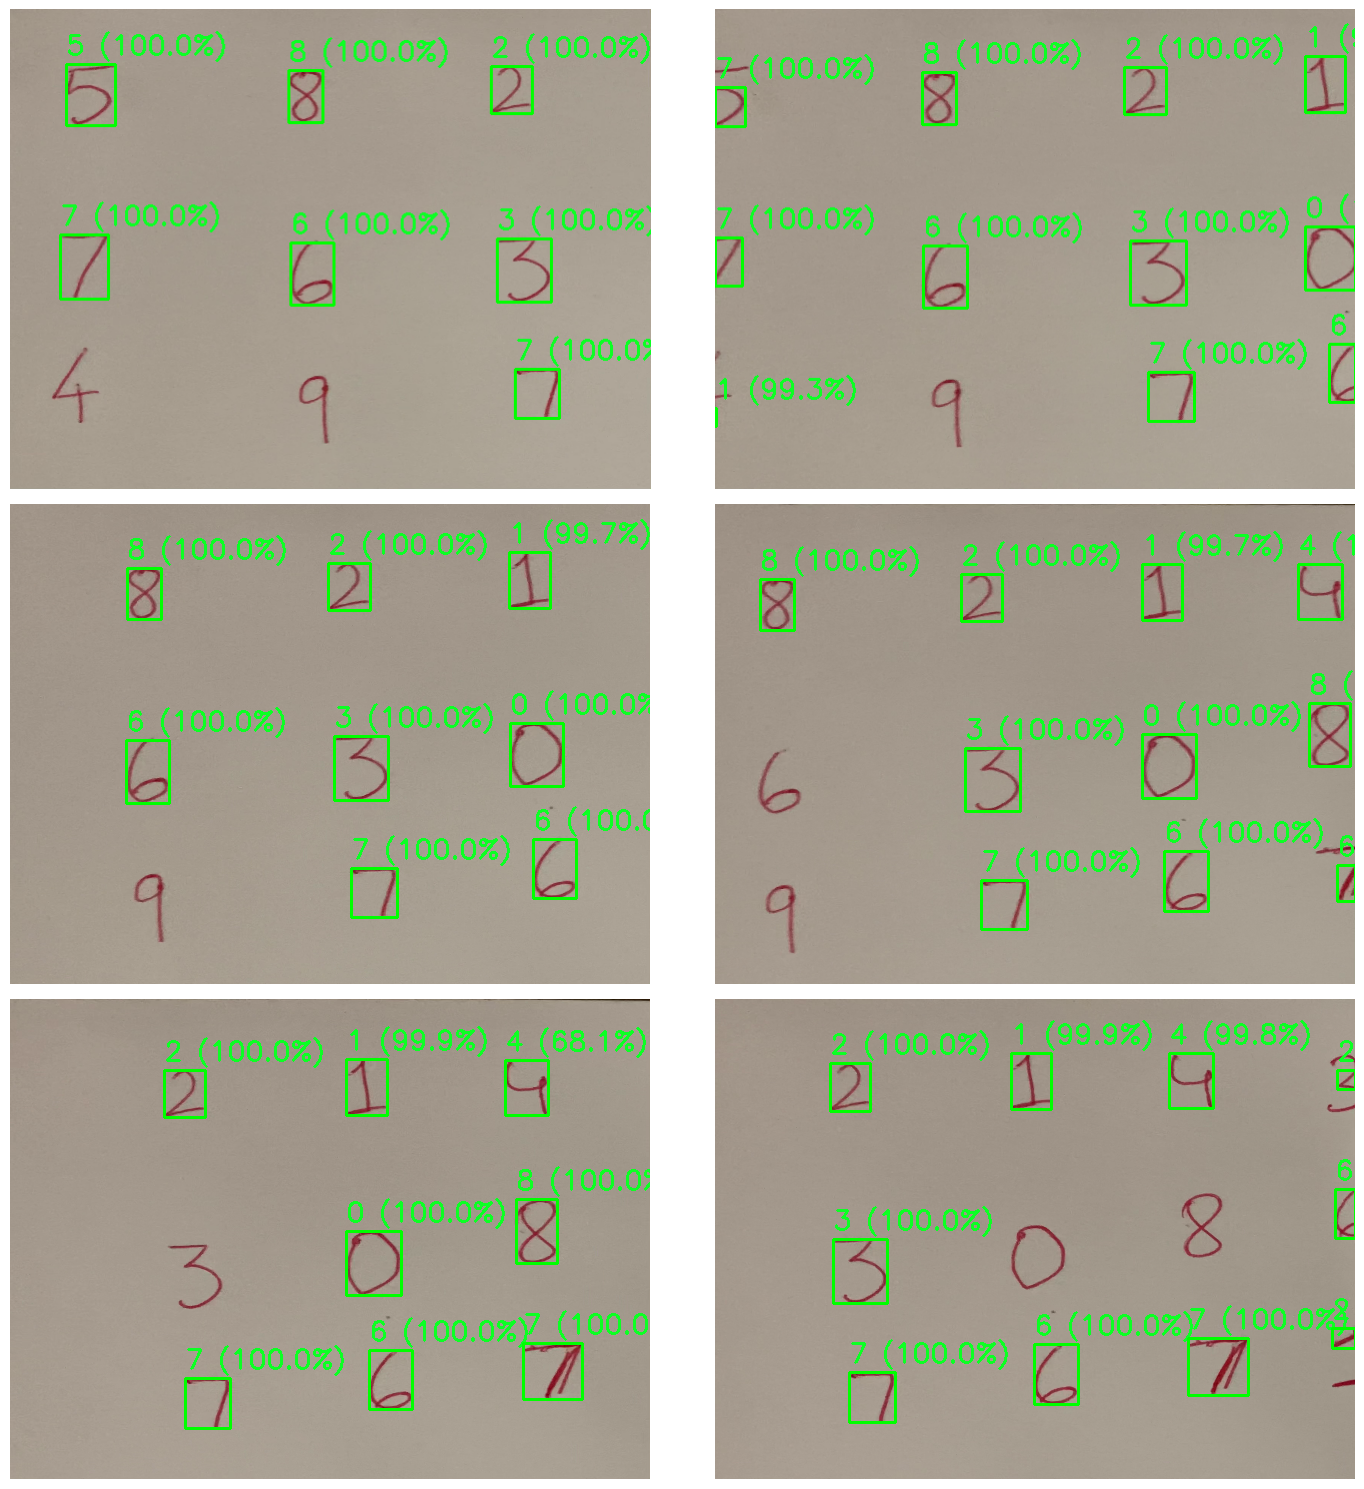

In [21]:
# display the annotated frames
print('Displaying annotated frames...')
display_images(marked_frames, cols=2)